## Import des librairies nécessaires

In [1]:
# Importations générales
import math
import numpy as np
import pandas as pd
from scipy.optimize import minimize, differential_evolution
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import warnings

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Préparation des données
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Web scraping et récupération de données
import requests
from bs4 import BeautifulSoup
import cloudscraper
import yfinance as yf

# Modèles statistiques
from arch import arch_model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# CVI SCRAPPING

In [2]:
import numpy as np
import pandas as pd
import requests
import cloudscraper
from bs4 import BeautifulSoup

def get_data_from_api(start_date, end_date):
    """
    Fetches historical financial data from the Investing.com API.
    """
    url = f"https://api.investing.com/api/financialdata/historical/1178491?start-date={start_date}&end-date={end_date}&time-frame=Daily&add-missing-rows=false"
    headers = {"domain-id": "www"}
    session = cloudscraper.create_scraper()

    r = session.get(url, headers=headers)
    if r.status_code == 200:
        data = r.json().get("data", [])
        filtered_data = [
            {
                "rowDate": row["rowDate"],
                "last_close": row.get("last_close"),
                "last_open": row.get("last_open"),
                "last_max": row.get("last_max"),
                "last_min": row.get("last_min"),
                "volume": row.get("volume"),
                "change_precent": row.get("change_precent"),
            }
            for row in data
        ]
        return pd.DataFrame(filtered_data)
    else:
        print(f"API Error: HTTP {r.status_code}")
        return None


def get_data_from_html(url):
    """
    Scrapes historical financial data from the Investing.com website.
    """
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        print(f"Error fetching page: HTTP {response.status_code}")
        return None

    soup = BeautifulSoup(response.content, "html.parser")
    table = soup.find("table", class_="freeze-column-w-1 w-full overflow-x-auto text-xs leading-4")

    if not table:
        print("Table not found in the HTML page.")
        return None

    headers = [th.text.strip() for th in table.find("thead").find_all("th")]
    rows = []
    for tr in table.find("tbody").find_all("tr"):
        row = [td.text.strip() for td in tr.find_all("td")]
        rows.append(row)

    df = pd.DataFrame(rows, columns=headers)

    return df


def clean_and_prepare_dataframe(df, source):
    """
    Cleans and prepares a DataFrame for standardization before merging.
    """
    if source == "api":
        df.rename(columns={
            "rowDate": "Date",
            "last_close": "Price",
            "last_open": "Open",
            "last_max": "High",
            "last_min": "Low",
            "volume": "Volume",
            "change_precent": "Change %"
        }, inplace=True)
    elif source == "html":
        df.rename(columns={
            "Date": "Date",
            "Dernier": "Price",
            "Ouv.": "Open",
            "Plus Haut": "High",
            "Plus Bas": "Low",
            "Vol.": "Volume",
            "Variation %": "Change %"
        }, inplace=True)

    for col in ["Price", "Open", "High", "Low", "Change %"]:
        if col in df.columns:
            df[col] = df[col].astype(str)
            df[col] = (
                df[col]
                .str.replace(",", "", regex=False)
                .str.replace("%", "", regex=False)
                .replace("", None)
            )
            if source == "html" and col != "Change %":
                df[col] = pd.to_numeric(df[col], errors="coerce") / 10000
            else:
                df[col] = pd.to_numeric(df[col], errors="coerce")

    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce", dayfirst=True).dt.strftime("%Y-%m-%d")

    return df


def main():
    """
    Main function to fetch, clean, and save financial data.
    """
    start_date = "2019-03-31"
    end_date = "2024-10-29"

    print(f"Fetching data from API for the period {start_date} to {end_date}...")
    df_api = get_data_from_api(start_date, end_date)
    if df_api is not None:
        df_api = clean_and_prepare_dataframe(df_api, "api")

    print("Fetching data via web scraping...")
    scraping_url = "https://fr.investing.com/indices/crypto-volatility-index-historical-data"
    df_html = get_data_from_html(scraping_url)
    if df_html is not None:
        df_html = clean_and_prepare_dataframe(df_html, "html")

    # Merge API and Scraped data, prioritizing unique dates
    if df_api is not None and df_html is not None:
        df_combined = pd.concat([df_api, df_html], ignore_index=True).drop_duplicates(subset="Date")
    elif df_api is not None:
        df_combined = df_api
    elif df_html is not None:
        df_combined = df_html
    else:
        print("No data available.")
        return

    # Remove unnecessary columns
    if "Volume" in df_combined.columns:
        df_combined.drop(columns=["Volume"], inplace=True)

    df_combined.sort_values("Date", inplace=True)
    df_combined.to_csv("cvi.csv", index=False)
    print("Data saved in cvi.csv")


if __name__ == "__main__":
    main()


Fetching data from API for the period 2019-03-31 to 2024-10-29...
Fetching data via web scraping...
Data saved in cvi.csv


# IMPORT CRYPTO

**Récupération des données de Yahoo Finance grâce à `yfinance`**

In [3]:
cryptos = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'ADA-USD']

data = yf.download(cryptos, start='2019-03-11', end='2024-11-28', interval='1d')


[*********************100%***********************]  4 of 4 completed


**Traitement des données et calcul des Log_returns**

In [4]:
crypto_prices = data['Close']

crypto_prices = crypto_prices.dropna()

print('Crypto Course :')
print(crypto_prices.head())

log_returns=np.log(crypto_prices/crypto_prices.shift(1))
log_returns=log_returns.dropna()


last_30_returns = log_returns.tail(30)

Crypto Course :
Ticker       ADA-USD    BNB-USD      BTC-USD     ETH-USD
Date                                                    
2019-03-11  0.047633  14.514414  3905.227295  133.834030
2019-03-12  0.047397  15.406131  3909.156250  134.442886
2019-03-13  0.046590  15.115124  3906.717285  133.263077
2019-03-14  0.048055  15.051104  3924.369141  133.711594
2019-03-15  0.050077  15.077102  3960.911133  137.691788


In [5]:
# Réorganisation du DataFrame
close_data_long = data['Close'].stack().reset_index()
close_data_long.columns = ['Date', 'Crypto', 'Close']

# Avec un pivot
df = close_data_long.pivot(index='Date', columns='Crypto', values='Close')
df.reset_index(inplace=True)

df.set_index("Date", inplace=True)

# Réorganisation du DataFrame
close_data_long = data['Close'].stack().reset_index()
close_data_long.columns = ['Date', 'Crypto', 'Close']

# Avec un pivot
df = close_data_long.pivot(index='Date', columns='Crypto', values='Close')
df.columns.name = None

crypto_list = ['ADA-USD', 'BNB-USD', 'BTC-USD', 'ETH-USD']

print(df.head())

             ADA-USD    BNB-USD      BTC-USD     ETH-USD
Date                                                    
2019-03-11  0.047633  14.514414  3905.227295  133.834030
2019-03-12  0.047397  15.406131  3909.156250  134.442886
2019-03-13  0.046590  15.115124  3906.717285  133.263077
2019-03-14  0.048055  15.051104  3924.369141  133.711594
2019-03-15  0.050077  15.077102  3960.911133  137.691788


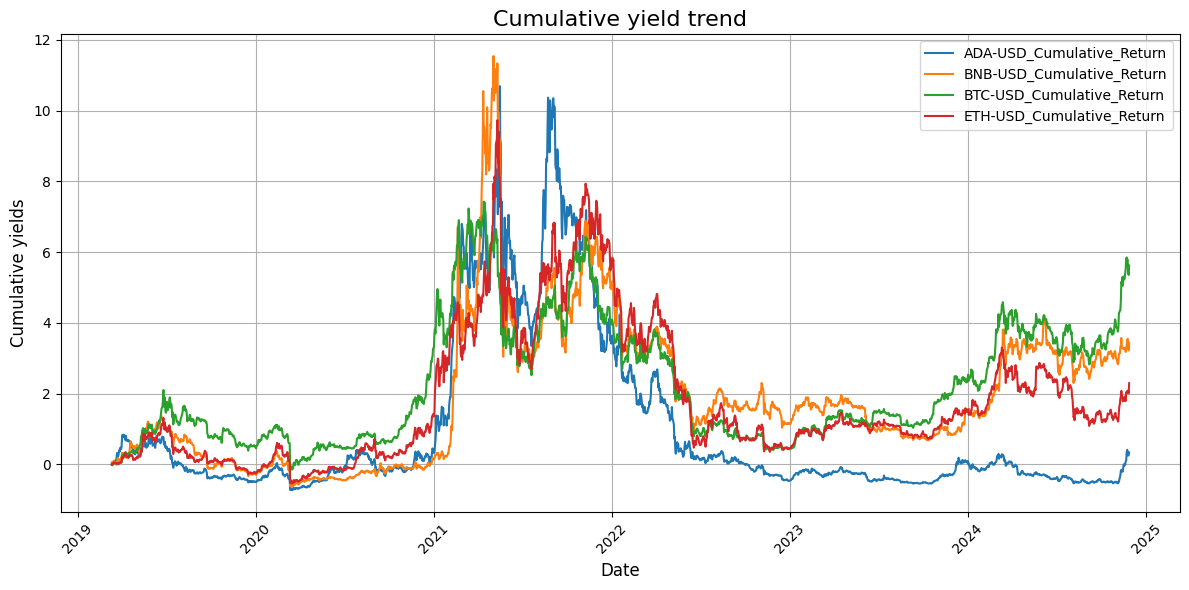

In [6]:


for col in crypto_list:
    df[f'{col}_Log_Returns'] = np.log(df[f'{col}'] / df[f'{col}'].shift(1))


# Calcul des rendements cumulés
for col in crypto_list:
    df[f'{col}_Cumulative_Return'] = (1 + df[f'{col}_Log_Returns']).cumprod() - 1

# Affichage des résultats
return_colums = ['ADA-USD_Cumulative_Return', 'BNB-USD_Cumulative_Return',
          'BTC-USD_Cumulative_Return', 'ETH-USD_Cumulative_Return']

plt.figure(figsize=(12, 6))

for col in return_colums:
    plt.plot(df.index, df[col], label=col)
plt.title('Cumulative yield trend', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative yields', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
for col in crypto_list:
    df[f'{col}_Volatility'] = (
        df[f'{col}_Log_Returns']
        .rolling(window=30)
        .std(ddof=1)
    )

for col in crypto_list:
    df[f'{col}_Lagged_Volatility'] = df[f'{col}_Volatility'].shift(1)

print(df.tail())

             ADA-USD     BNB-USD       BTC-USD      ETH-USD  \
Date                                                          
2024-11-23  1.066237  651.197266  97777.281250  3396.223389   
2024-11-24  1.023106  660.317566  98013.820312  3363.659912   
2024-11-25  0.945689  636.639709  93102.296875  3413.543945   
2024-11-26  0.961232  613.587280  91985.320312  3326.517334   
2024-11-27  1.013346  644.948486  95962.531250  3657.249268   

            ADA-USD_Log_Returns  BNB-USD_Log_Returns  BTC-USD_Log_Returns  \
Date                                                                        
2024-11-23             0.053767             0.027531            -0.012404   
2024-11-24            -0.041293             0.013908             0.002416   
2024-11-25            -0.078685            -0.036517            -0.051410   
2024-11-26             0.016302            -0.036881            -0.012070   
2024-11-27             0.052797             0.049848             0.042329   

            ETH-US

# GARCH

In [8]:
# Importation de la bibliothèque GARCH
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings("ignore")

# Dictionnaire pour stocker les prédictions optimales
predicted_all_optimal = {}

# Définition des plages de recherche pour p, q et la constante
p_values = range(1, 5)
q_values = range(1, 5)
constant_values = [True, False]  # True = modèle avec constante, False = modèle sans constante

params_summary = []



# Boucle sur chaque cryptomonnaie
for col in crypto_list:
    warnings.filterwarnings("ignore")

    best_aic = np.inf
    best_p = None
    best_q = None
    best_constant = None
    best_model = None
    best_predictions = None

    # Boucle sur les valeurs de p, q et l'inclusion ou non de la constante
    for p in p_values:
        warnings.filterwarnings("ignore")
        for q in q_values:
            warnings.filterwarnings("ignore")
            for constant in constant_values:
                try:
                    # Modèle GARCH(p, q) avec ou sans constante
                    garch_model = arch_model(df[f'{col}_Log_Returns'].dropna(), vol='Garch', p=p, q=q, mean='Constant' if constant else 'Zero')

                    # Ajustement du modèle
                    garch_fit = garch_model.fit(disp='off')

                    # Récupérer l'AIC
                    aic = garch_fit.aic

                    # Vérifier si c'est le meilleur modèle (AIC le plus bas)
                    if aic < best_aic:
                        best_aic = aic
                        best_p = p
                        best_q = q
                        best_constant = constant
                        best_model = garch_fit
                        best_predictions = garch_fit.conditional_volatility
                except Exception as e:
                    print(f"Error for {col} with p={p}, q={q}, constant={constant}: {e}")

    # Alignement des prédictions avec la volatilité réalisée
    predicted_volatility = pd.Series(best_predictions, index=df[f'{col}_Log_Returns'].dropna().index)
    realized_volatility = df[f'{col}_Volatility'].dropna()
    realized_volatility_aligned, predicted_volatility_aligned = realized_volatility.align(predicted_volatility[30:], join='inner')

    predicted_all_optimal[col] = predicted_volatility_aligned

    # Stocker les paramètres optimaux et AIC dans le tableau récapitulatif
    params_summary.append({
        'Crypto': col,
        'Best p': best_p,
        'Best q': best_q,
        'Constant': 'Yes' if best_constant else 'No',
        'AIC': best_aic
    })

    # Affichage des paramètres optimaux
    #print(f"{col}: Best p={best_p}, q={best_q}, Constant={'Yes' if best_constant else 'No'} with AIC={best_aic:.2f}")

params_df = pd.DataFrame(params_summary)
print(params_df)

c:\Users\dumas\PycharmProjects\Finance\.venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\dumas\PycharmProjects\Finance\.venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\dumas\PycharmProjects\Finance\.venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\dumas\PycharmProjects\Finance\.venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional deri

    Crypto  Best p  Best q Constant          AIC
0  ADA-USD       4       3      Yes -6872.671791
1  BNB-USD       2       3      Yes -7742.002281
2  BTC-USD       4       4      Yes -8369.956364
3  ETH-USD       4       3      Yes -7505.190659


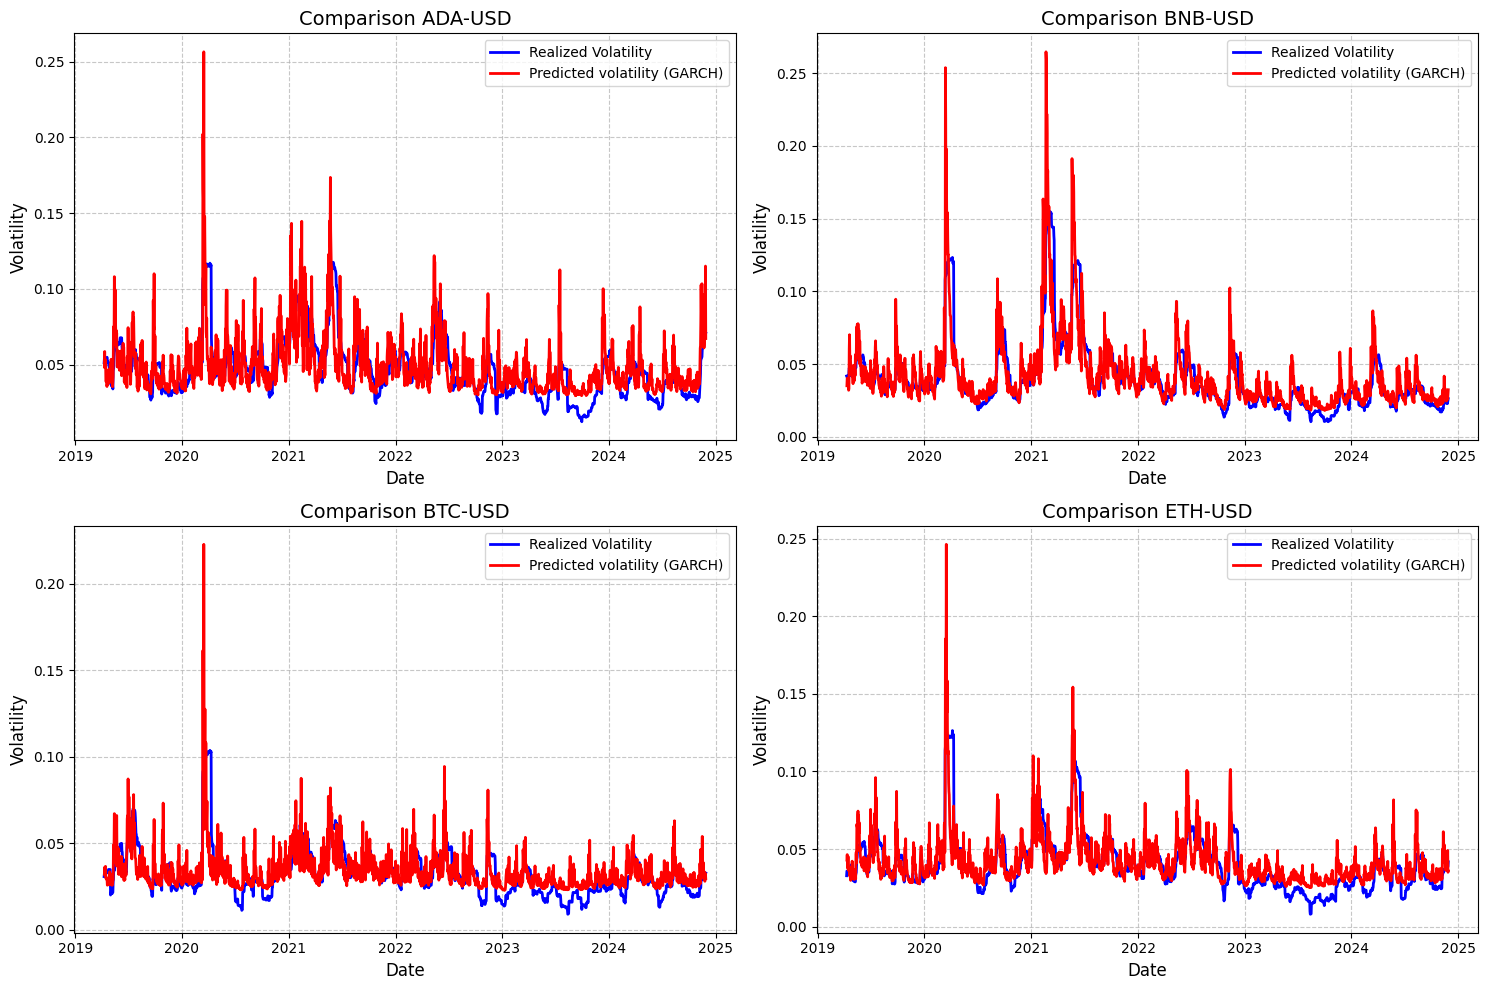

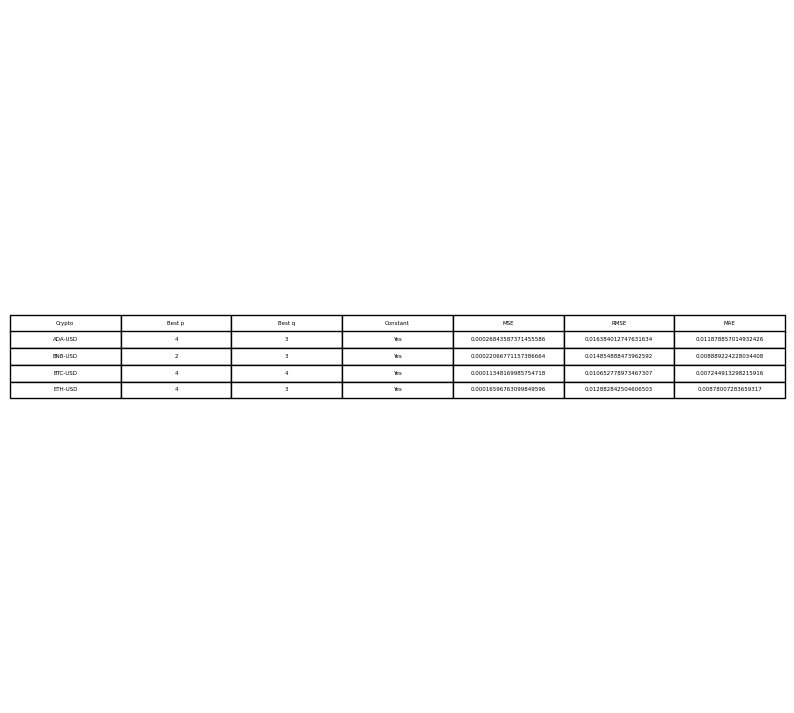


Summary of model indicators :
    Crypto  Best p  Best q Constant       MSE      RMSE       MAE
0  ADA-USD       4       3      Yes  0.000268  0.016384  0.011879
1  BNB-USD       2       3      Yes  0.000221  0.014855  0.008889
2  BTC-USD       4       4      Yes  0.000113  0.010653  0.007245
3  ETH-USD       4       3      Yes  0.000166  0.012883  0.008780


In [9]:
# Dictionnaire des paramètres optimaux des GARCH pour chaque crypto
best_garch_params = {
    "ADA-USD": {"p": 4, "q": 3, "constant": True},
    "BNB-USD": {"p": 2, "q": 3, "constant": True},
    "BTC-USD": {"p": 4, "q": 4, "constant": True},
    "ETH-USD": {"p": 4, "q": 3, "constant": True},
}

# Initialisation des structures pour collecter les résultats
metrics_summary = []

# Création des subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()  # Aplatir les axes pour un accès plus facile

predicted_all = []
garch_predictions = {}

# Boucle sur chaque crypto pour utiliser les meilleurs paramètres
for i, col in enumerate(crypto_list):
    try:

        if col in best_garch_params:
            p = best_garch_params[col]["p"]
            q = best_garch_params[col]["q"]
            constant = best_garch_params[col]["constant"]

            # Définition du modèle avec les paramètres optimaux
            garch_model_dynamic = arch_model(
                df[f'{col}_Log_Returns'].dropna(),
                vol='Garch',
                p=p,
                q=q,
                mean="Constant" if constant else "Zero"
            )

            # Ajustement du modèle
            garch_fit_dynamic = garch_model_dynamic.fit(disp='off')

            # Extraction de la volatilité conditionnelle prédite
            predicted_volatility_dynamic = garch_fit_dynamic.conditional_volatility

            # Alignement avec l'index des log-returns
            predicted_volatility_dynamic = pd.Series(predicted_volatility_dynamic, index=df[f'{col}_Log_Returns'].dropna().index)

            # Alignement avec la volatilité réalisée
            realized_volatility = df[f'{col}_Volatility'].dropna()
            predicted_volatility_trimmed = predicted_volatility_dynamic[30:]

            realized_volatility_aligned, predicted_volatility_aligned = realized_volatility.align(predicted_volatility_trimmed, join='inner')

            predicted_all.append(predicted_volatility_aligned)

            garch_predictions[col] = pd.Series(garch_fit_dynamic.conditional_volatility, index=df[f'{col}_Log_Returns'].dropna().index)

            # Calcul des métriques d'évaluation
            mse = mean_squared_error(realized_volatility_aligned, predicted_volatility_aligned)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(realized_volatility_aligned, predicted_volatility_aligned)

            # Ajout des résultats dans la liste
            metrics_summary.append({
                'Crypto': col,
                'Best p': p,
                'Best q': q,
                'Constant': 'Yes' if constant else 'No',
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae
            })

            # Graphique comparatif pour chaque crypto dans un subplot
            ax = axes[i]  # Récupérer l'axe correspondant au subplot
            ax.plot(df[f'{col}_Volatility'].index, df[f'{col}_Volatility'], label='Realized Volatility', color='blue', linewidth=2)
            ax.plot(predicted_volatility_aligned.index, predicted_volatility_aligned, label='Predicted volatility (GARCH)', color='red', linewidth=2)
            ax.set_title(f'Comparison {col}', fontsize=14)
            ax.set_xlabel("Date", fontsize=12)
            ax.set_ylabel("Volatility", fontsize=12)
            ax.legend(fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.7)

    except Exception as e:
        print(f"Error for {col}: {e}")

# Ajuster l'espacement entre les subplots
plt.tight_layout()

# Création du DataFrame récapitulatif des métriques
metrics_df = pd.DataFrame(metrics_summary)

# Affichage du tableau récapitulatif sous le graphique
fig2, ax2 = plt.subplots(figsize=(10, 9))  # Créer un subplot pour le tableau
ax2.axis('tight')
ax2.axis('off')
table = ax2.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')

# Afficher les résultats
plt.show()

# Affichage du récapitulatif des métriques
print("\nSummary of model indicators :")
print(metrics_df)


# LSTM

**Données :**

In [10]:
volatility_columns = [col for col in df.columns if col.endswith('_Volatility') and not col.endswith('Lagged_Volatility')]

datalstm = df[volatility_columns].dropna()

# Create a new DataFrame with the scaled data and original columns
datalstm = pd.DataFrame(datalstm, columns=datalstm.columns, index=datalstm.index)

print(datalstm)


            ADA-USD_Volatility  BNB-USD_Volatility  BTC-USD_Volatility  \
Date                                                                     
2019-04-10            0.051223            0.041796            0.030690   
2019-04-11            0.054035            0.041164            0.032584   
2019-04-12            0.053719            0.041421            0.032545   
2019-04-13            0.053753            0.041399            0.032564   
2019-04-14            0.053596            0.041821            0.032578   
...                        ...                 ...                 ...   
2024-11-23            0.068655            0.023780            0.030549   
2024-11-24            0.067545            0.022790            0.029908   
2024-11-25            0.070831            0.023901            0.032115   
2024-11-26            0.070856            0.024933            0.032383   
2024-11-27            0.070792            0.026263            0.032747   

            ETH-USD_Volatility  
Date

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.0404
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0055
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0036
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0032
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0028
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0026
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0024
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0022
Epoch 9/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0021
Epoch 10/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0019
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[ADA-USD_Volatility] Root Mean Squared Error (RMSE) on test : 0.002839
[ADA-USD_Volatility] Root Mean Squared Error (RMSE) on train : 0.357448


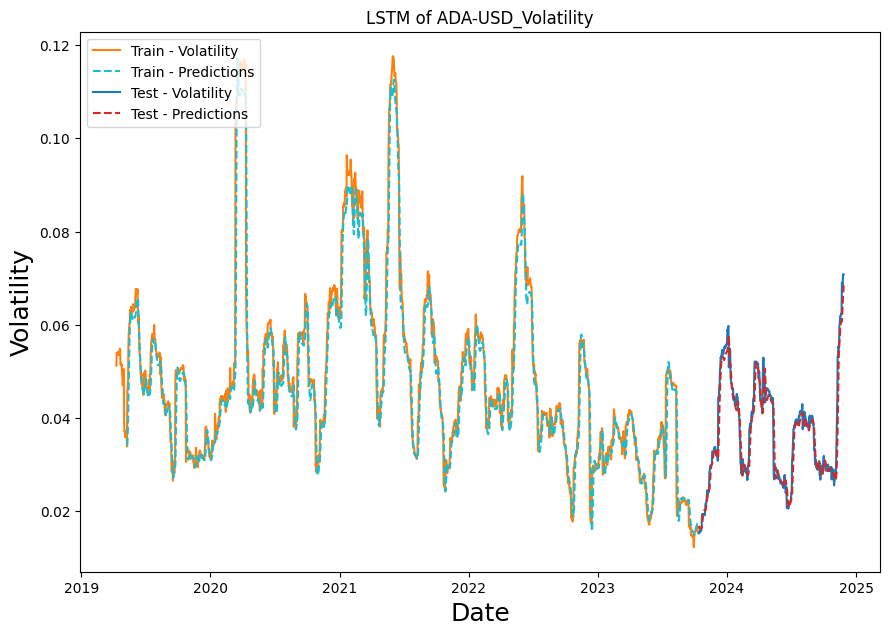

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0179
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0029
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0018
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0017
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0015
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0014
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0013
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0012
Epoch 9/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0011
Epoch 10/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0010
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
[BNB-USD_Volatility] Root Mean Squared Error (RMSE) on test : 0.002684
[BNB-USD_Volatility] Root Mean Squared Error (RMSE) on train : 0.253100


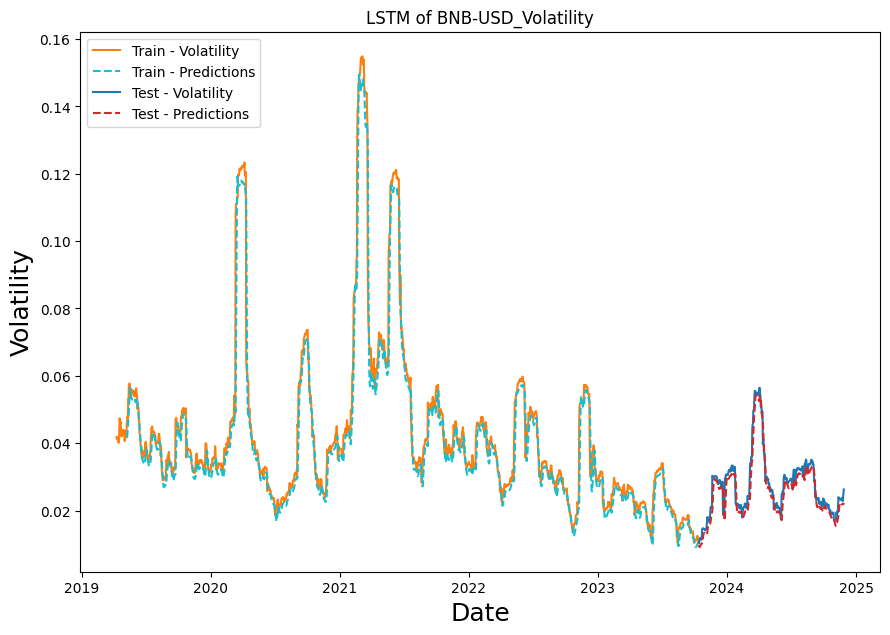

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0142
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0030
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0023
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0020
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0019
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0017
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0016
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0015
Epoch 9/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0014
Epoch 10/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0013
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[BTC-USD_Volatility] Root Mean Squared Error (RMSE) on test : 0.001749
[BTC-USD_Volatility] Root Mean Squared Error (RMSE) on train : 0.273872


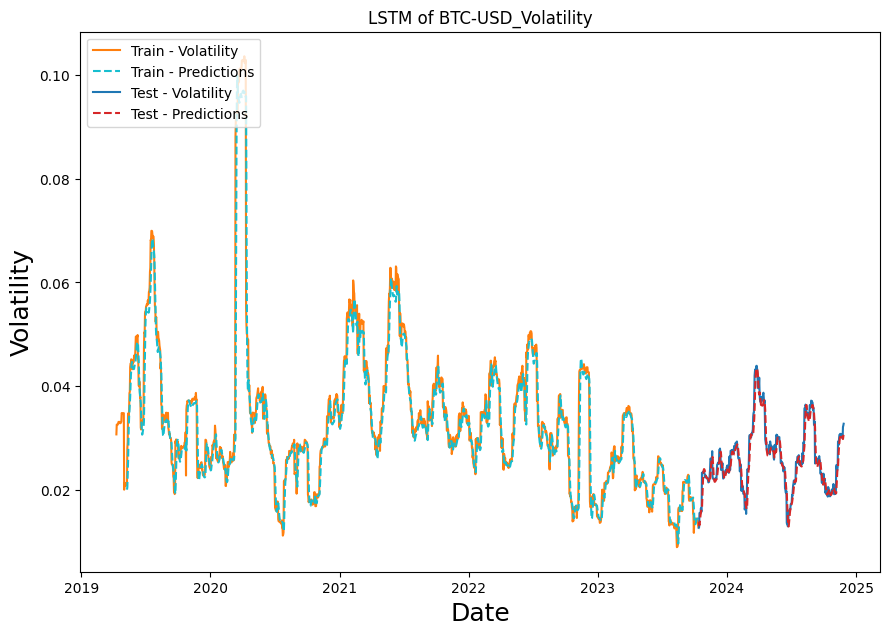

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0353
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0042
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0025
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0022
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0020
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0018
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0016
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0015
Epoch 9/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0014
Epoch 10/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0013
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
[ETH-USD_Volatility] Root Mean Squared Error (RMSE) on test : 0.002954
[ETH-USD_Volatility] Root Mean Squared Error (RMSE) on train : 0.296959


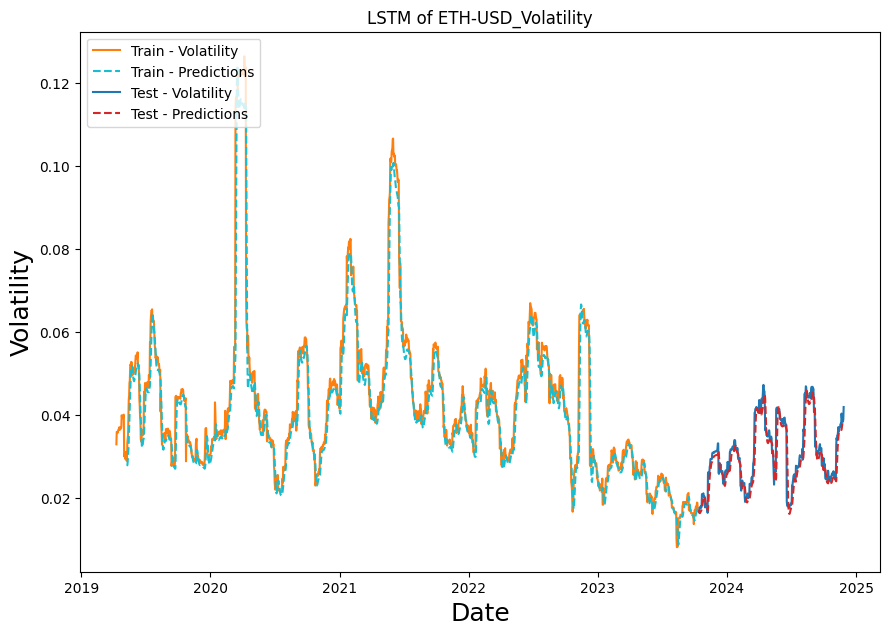

In [11]:
# Normalisation des données
scaler = MinMaxScaler()

# Définir le lookback (nombre de pas de temps)
lookback = 30  

for col in datalstm.columns:
    data = datalstm[col].values.reshape(-1, 1)  # Convertir la colonne en tableau 2D
    scaled_data = scaler.fit_transform(data)  # Normaliser les données

    # Définir la taille du jeu d'entraînement (80% des données)
    training_data_len = math.ceil(len(data) * 0.8)

    # Séparer les données d'entraînement
    train_data = scaled_data[:training_data_len]
    X_train = []
    y_train = []

    for i in range(lookback, len(train_data)):
        X_train.append(train_data[i - lookback:i, 0])
        y_train.append(train_data[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # Préparer les données de test
    test_data = scaled_data[training_data_len - lookback:]
    X_test = []
    y_test = data[training_data_len:]

    for i in range(lookback, len(test_data)):
        X_test.append(test_data[i - lookback:i, 0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Fixer la seed pour reproductibilité
    tf.random.set_seed(42)

    # Construction du modèle LSTM
    model_1 = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])

    model_1.compile(optimizer='adam', loss='mse')

    # Entraînement du modèle
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
    history = model_1.fit(X_train, y_train, batch_size=32, epochs=10)

    # Prédictions sur les jeux de test et train
    predictions_test = model_1.predict(X_test)
    predictions_test = scaler.inverse_transform(predictions_test)

    predictions_train = model_1.predict(X_train)
    predictions_train = scaler.inverse_transform(predictions_train)

    # Calcul du RMSE pour le test
    rmse_test = np.sqrt(np.mean((predictions_test - y_test) ** 2))
    print(f"[{col}] Root Mean Squared Error (RMSE) on test : {rmse_test:.6f}")

    # Calcul du RMSE pour le train
    rmse_train = np.sqrt(np.mean((predictions_train - y_train) ** 2))
    print(f"[{col}] Root Mean Squared Error (RMSE) on train : {rmse_train:.6f}")

    #data for model_1
    data = datalstm[col]
    valid_test = pd.DataFrame(data[training_data_len:]) # Convert to DataFrame
    valid_test = valid_test.rename(columns={0: col})

    valid_train = pd.DataFrame(data[:training_data_len]) # Convert to DataFrame
    valid_train = valid_train.rename(columns={0: col}) # Fix: Use valid_train instead of valid_test


    valid_test['Predictions'] = predictions_test
    valid_train['Predictions'] = np.nan  # Initialise avec NaN

    # Fix: Adjust the slice to match predictions_train shape
    valid_train.iloc[lookback:, valid_train.columns.get_loc('Predictions')] = predictions_train.flatten()

    # Visualized the data
    plt.figure(figsize=(10, 6))
    plt.title(f'LSTM of {col}')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Volatility', fontsize=18)

    # Train
    plt.plot(valid_train[f'{col}'].index, valid_train[f'{col}'] , label='Train - Volatility', color='#ff7f0e')
    plt.plot(valid_train['Predictions'].index, valid_train['Predictions'], label='Train - Predictions', linestyle='--', color='#17becf')

    # Test
    plt.plot(valid_test[f'{col}'].index, valid_test[f'{col}'], label='Test - Volatility', color='#1f77b4')
    plt.plot(valid_test['Predictions'].index, valid_test['Predictions'], label='Test - Predictions', linestyle='--', color='#d62728')

    plt.legend(loc='upper left')

    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=1,
                        wspace=0.4,
                        hspace=0.4)
    plt.show()

**Evaluation :**

# LSTM GARCH

In [12]:
# Fixer la seed pour reproductibilité
tf.random.set_seed(42)
for col in garch_predictions:
    datalstm[f'{col}_GARCH_Volatility'] = garch_predictions[col]

# Normalisation des données
scaler = MinMaxScaler()

# Définition du lookback
lookback = 30

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 0.0351 - val_loss: 0.0468
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0034 - val_loss: 0.0493
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0029 - val_loss: 0.0483
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0026 - val_loss: 0.0471
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0024 - val_loss: 0.0465
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0022 - val_loss: 0.0461
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0021 - val_loss: 0.0459
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0019 - val_loss: 0.0450
Epoch 9/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0018 - val_loss: 0.0445
Epoch 10/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0016 - val_loss: 0.0464
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
[ADA-USD] RMSE on test : 0.002635
[ADA-USD] RMSE on train : 0.347405


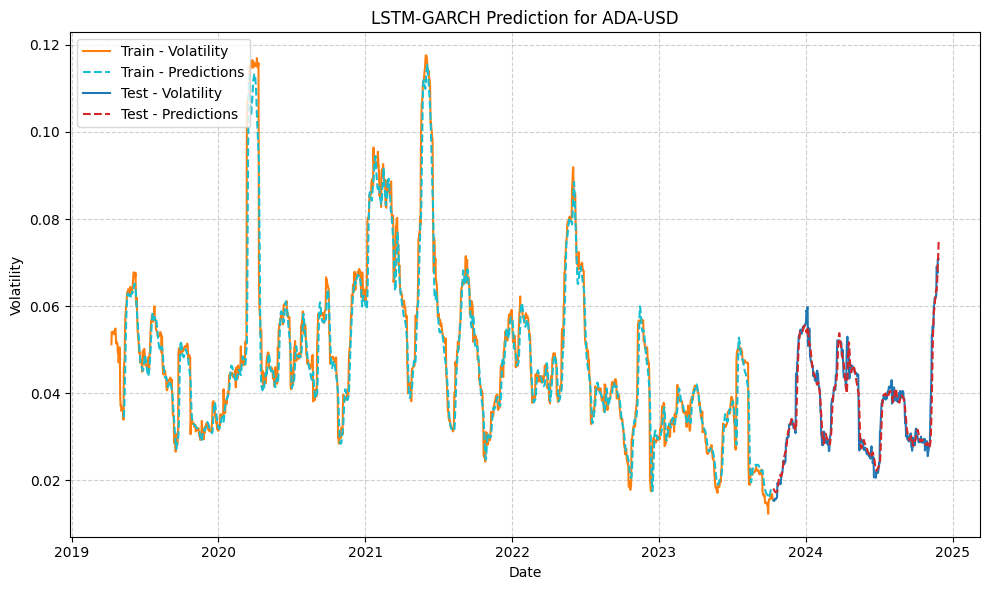

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 0.0185 - val_loss: 0.0113
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0024 - val_loss: 0.0105
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0021 - val_loss: 0.0106
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0020 - val_loss: 0.0107
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0019 - val_loss: 0.0109
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0017 - val_loss: 0.0105
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0017 - val_loss: 0.0105
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0016 - val_loss: 0.0098
Epoch 9/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0016 - val_loss: 0.0101
Epoch 10/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0015 - val_loss: 0.0101
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[BNB-USD] RMSE on test : 0.002453
[BNB-USD] RMSE on train : 0.234988


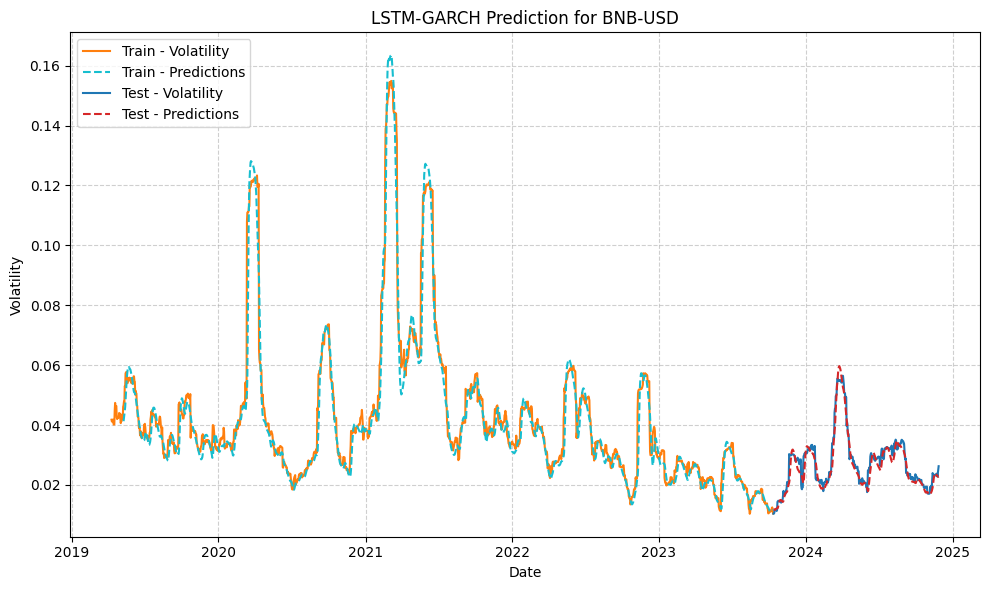

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0326 - val_loss: 0.0330
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0032 - val_loss: 0.0320
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0024 - val_loss: 0.0306
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0023 - val_loss: 0.0298
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0022 - val_loss: 0.0291
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0021 - val_loss: 0.0288
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0019 - val_loss: 0.0286
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0018 - val_loss: 0.0282
Epoch 9/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0017 - val_loss: 0.0275
Epoch 10/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0016 - val_loss: 0.0271
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[BTC-USD] RMSE on test : 0.001966
[BTC-USD] RMSE on train : 0.266477


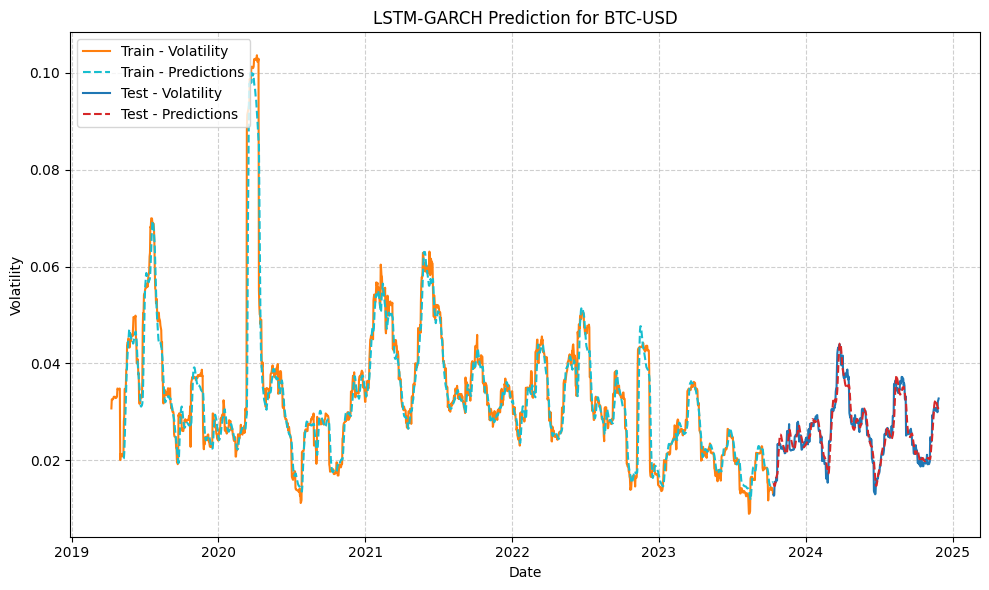

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 0.0189 - val_loss: 0.0294
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0023 - val_loss: 0.0335
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0020 - val_loss: 0.0333
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0018 - val_loss: 0.0324
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0017 - val_loss: 0.0322
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0016 - val_loss: 0.0315
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0015 - val_loss: 0.0303
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0014 - val_loss: 0.0296
Epoch 9/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0013 - val_loss: 0.0288
Epoch 10/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0012 - val_loss: 0.0283
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[ETH-USD] RMSE on test : 0.002612
[ETH-USD] RMSE on train : 0.286722


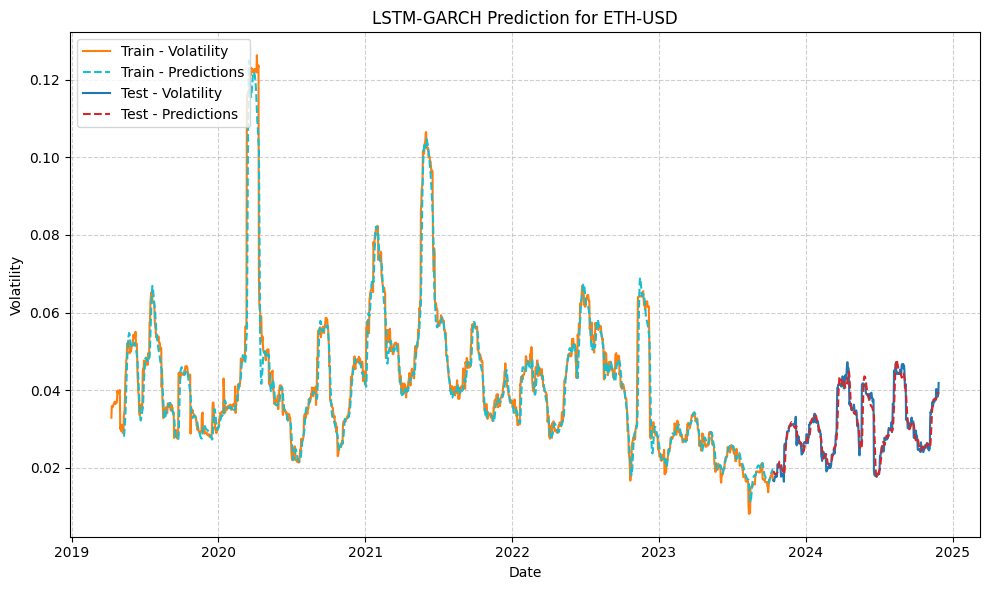

In [13]:
for col in crypto_list:
    # Création des données avec Volatilité + GARCH
    new_data = datalstm[[f'{col}_Volatility', f'{col}_GARCH_Volatility']].dropna()

    # Normalisation des données
    scaled_data = scaler.fit_transform(new_data)

    # Définir la taille du jeu d'entraînement
    training_data_len = int(len(scaled_data) * 0.8)

    # Séparer les données d'entraînement
    train_data = scaled_data[:training_data_len]
    X_train = []
    y_train = []

    for i in range(lookback, len(train_data)):
        X_train.append(train_data[i - lookback:i])
        y_train.append(train_data[i, 0])  # On prédit la volatilité réelle

    X_train, y_train = np.array(X_train), np.array(y_train)

    # Préparer les données de test
    test_data = scaled_data[training_data_len - lookback:]
    X_test = []
    y_test = new_data.iloc[training_data_len:, 0].values

    for i in range(lookback, len(test_data)):
        X_test.append(test_data[i - lookback:i])

    X_test = np.array(X_test)

    # Reshape pour LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

    # Construction du modèle LSTM-GARCH
    model_lstm_garch = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(50, return_sequences=False),
        Dense(25, activation='relu'),
        Dense(1)
    ])

    # Compilation du modèle
    model_lstm_garch.compile(optimizer='adam', loss='mse')

    # Entraînement du modèle
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
    history = model_lstm_garch.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

    # Prédictions
    predictions_test = model_lstm_garch.predict(X_test)
    predictions_test = scaler.inverse_transform(np.hstack((predictions_test, np.zeros((predictions_test.shape[0], 1)))))[:, 0]

    predictions_train = model_lstm_garch.predict(X_train)
    predictions_train = scaler.inverse_transform(np.hstack((predictions_train, np.zeros((predictions_train.shape[0], 1)))))[:, 0]

    # Calcul du RMSE
    rmse_test = np.sqrt(np.mean((predictions_test - y_test) ** 2))
    rmse_train = np.sqrt(np.mean((predictions_train - y_train) ** 2))

    print(f"[{col}] RMSE on test : {rmse_test:.6f}")
    print(f"[{col}] RMSE on train : {rmse_train:.6f}")

    # Préparer les DataFrames pour affichage
    valid_test = pd.DataFrame(new_data.iloc[training_data_len:, 0])  # Volatilité réelle
    valid_train = pd.DataFrame(new_data.iloc[:training_data_len, 0])  # Volatilité réelle

    valid_test['Predictions'] = predictions_test
    valid_train['Predictions'] = np.nan
    valid_train.iloc[lookback:, valid_train.columns.get_loc('Predictions')] = predictions_train

    # Affichage des résultats
    plt.figure(figsize=(10, 6))
    plt.plot(valid_train.index, valid_train.iloc[:, 0], label='Train - Volatility', color='#ff7f0e')
    plt.plot(valid_train.index, valid_train['Predictions'], label='Train - Predictions', linestyle='--', color='#17becf')
    plt.plot(valid_test.index, valid_test.iloc[:, 0], label='Test - Volatility', color='#1f77b4')
    plt.plot(valid_test.index, valid_test['Predictions'], label='Test - Predictions', linestyle='--', color='#d62728')

    plt.title(f'LSTM-GARCH Prediction for {col}')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# LSTM GARCH CVI

### Extraction des données de la CVI

In [14]:
file_path = 'cvi.csv'
cvi_data = pd.read_csv(file_path)

# Convertir les dates en datetime si ce n'est pas déjà fait
cvi_data['Date'] = pd.to_datetime(cvi_data['Date'])

# Définir la colonne "Date" de cvi_data comme index pour la fusion
cvi_data.set_index('Date', inplace=True)

# Fusionner en utilisant l'index
datalstm = datalstm.join(cvi_data[['Price']], how='left')
# Renommer la colonne "Price" en "CVI" pour plus de clarté
datalstm.rename(columns={'Price': 'CVI'}, inplace=True)

# Vérifier si la colonne CVI est bien ajoutée
print(datalstm.head())

            ADA-USD_Volatility  BNB-USD_Volatility  BTC-USD_Volatility  \
Date                                                                     
2019-04-10            0.051223            0.041796            0.030690   
2019-04-11            0.054035            0.041164            0.032584   
2019-04-12            0.053719            0.041421            0.032545   
2019-04-13            0.053753            0.041399            0.032564   
2019-04-14            0.053596            0.041821            0.032578   

            ETH-USD_Volatility  ADA-USD_GARCH_Volatility  \
Date                                                       
2019-04-10            0.032865                  0.045264   
2019-04-11            0.035854                  0.048407   
2019-04-12            0.035798                  0.058644   
2019-04-13            0.035825                  0.048853   
2019-04-14            0.035664                  0.052234   

            BNB-USD_GARCH_Volatility  BTC-USD_GARCH_Volatili

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 0.0396 - val_loss: 0.0401
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0040 - val_loss: 0.0515
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0031 - val_loss: 0.0510
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0029 - val_loss: 0.0520
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0027 - val_loss: 0.0518
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0026 - val_loss: 0.0514
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0024 - val_loss: 0.0513
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0022 - val_loss: 0.0504
Epoch 9/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0021 - val_loss: 0.0501
Epoch 10/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0019 - val_loss: 0.0489
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[ADA-USD] RMSE on test : 0.002885
[ADA-USD] RMSE on train : 0.346257


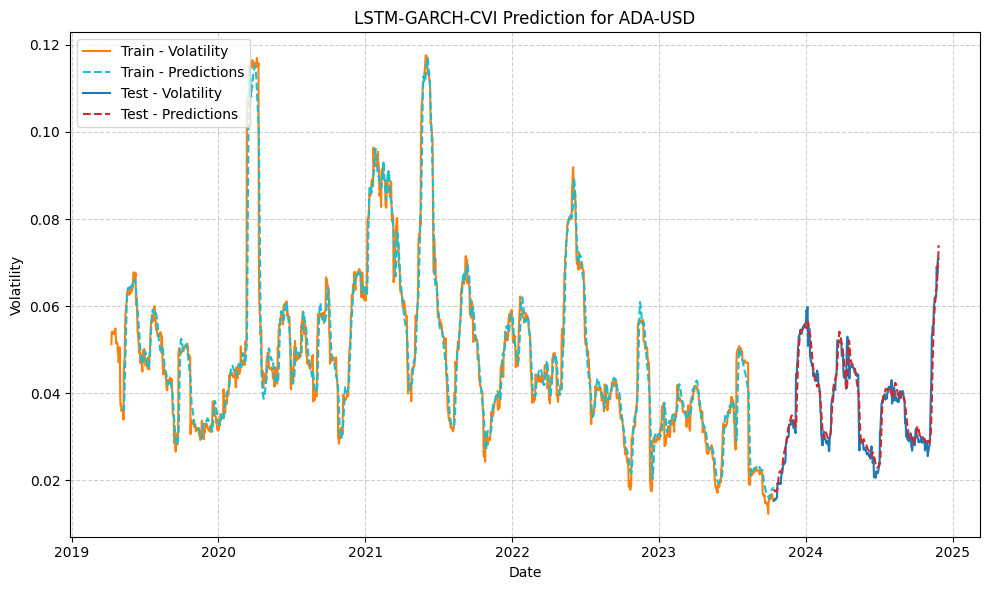

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 0.0145 - val_loss: 0.0101
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0019 - val_loss: 0.0103
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0018 - val_loss: 0.0107
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0017 - val_loss: 0.0107
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0015 - val_loss: 0.0107
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0015 - val_loss: 0.0108
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0014 - val_loss: 0.0109
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0013 - val_loss: 0.0108
Epoch 9/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0012 - val_loss: 0.0108
Epoch 10/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0012 - val_loss: 0.0107
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
[BNB-USD] RMSE on test : 0.002267
[BNB-USD] RMSE on train : 0.235394

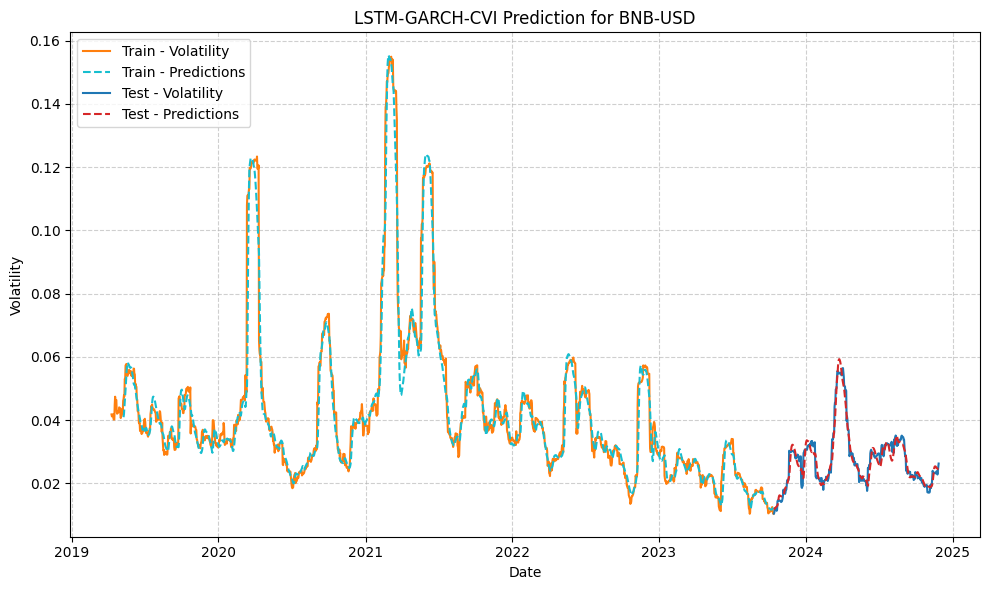

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 0.0208 - val_loss: 0.0212
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0033 - val_loss: 0.0304
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0025 - val_loss: 0.0280
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0024 - val_loss: 0.0274
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0022 - val_loss: 0.0270
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0021 - val_loss: 0.0266
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0020 - val_loss: 0.0262
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0019 - val_loss: 0.0260
Epoch 9/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0018 - val_loss: 0.0258
Epoch 10/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0017 - val_loss: 0.0258
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[BTC-USD] RMSE on test : 0.001913
[BTC-USD] RMSE on train : 0.265605


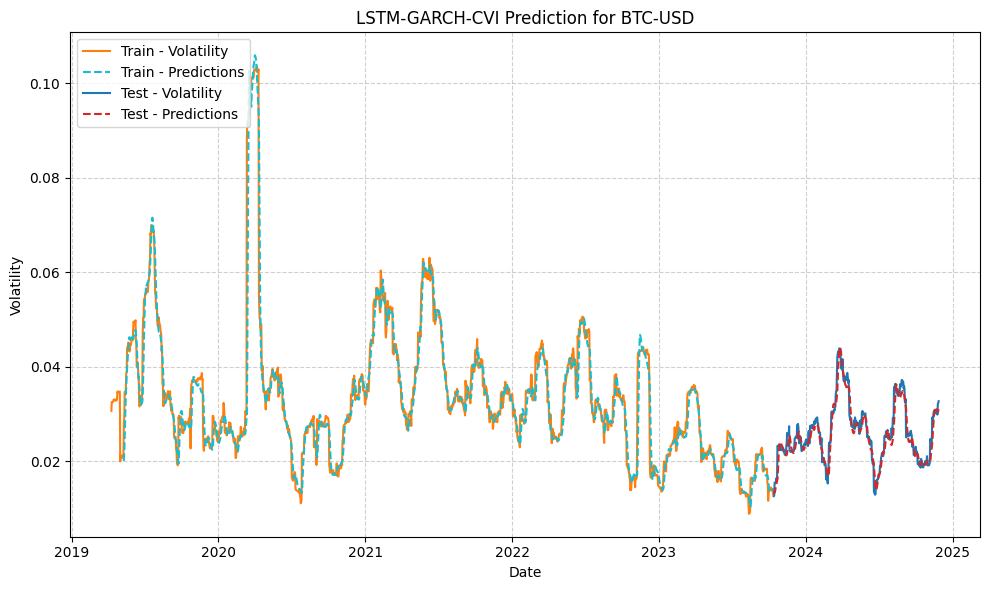

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 0.0186 - val_loss: 0.0242
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0027 - val_loss: 0.0308
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0022 - val_loss: 0.0290
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0020 - val_loss: 0.0311
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0018 - val_loss: 0.0324
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0017 - val_loss: 0.0324
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0016 - val_loss: 0.0315
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0015 - val_loss: 0.0307
Epoch 9/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0014 - val_loss: 0.0293
Epoch 10/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0013 - val_loss: 0.0277
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
[ETH-USD] RMSE on test : 0.002782
[ETH-USD] RMSE on train : 0.285484


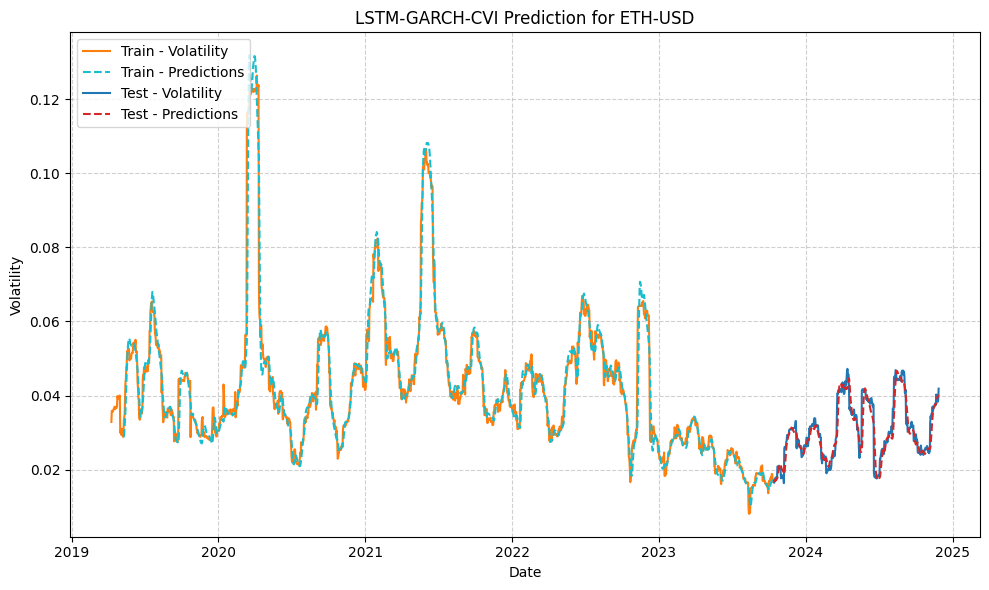

In [15]:
volatility_predictions = pd.DataFrame(index=datalstm.index)

for col in crypto_list:
    required_cols = [f'{col}_Volatility', f'{col}_GARCH_Volatility', 'CVI']


    new_data = datalstm[required_cols].dropna()

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(new_data)

    training_data_len = int(len(scaled_data) * 0.8)

    train_data = scaled_data[:training_data_len]
    X_train, y_train = [], []

    for i in range(lookback, len(train_data)):
        X_train.append(train_data[i - lookback:i])  
        y_train.append(train_data[i, 0])  

    X_train, y_train = np.array(X_train), np.array(y_train)


    test_data = scaled_data[training_data_len - lookback:]
    X_test, y_test = [], new_data.iloc[training_data_len:, 0].values

    for i in range(lookback, len(test_data)):
        X_test.append(test_data[i - lookback:i])

    X_test = np.array(X_test)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))


    model_lstm_garch = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(50, return_sequences=False),
        Dense(25, activation='relu'),
        Dense(1)
    ])

    model_lstm_garch.compile(optimizer='adam', loss='mse')
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
    history = model_lstm_garch.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

    predictions_test = model_lstm_garch.predict(X_test)
    predictions_test = scaler.inverse_transform(
        np.hstack((predictions_test, np.zeros((predictions_test.shape[0], 2))))
    )[:, 0]

    volatility_predictions[f"{col}_LSTM_GARCH_CVI_Pred"] = np.nan
    volatility_predictions.loc[new_data.index[training_data_len:], f"{col}_LSTM_GARCH_CVI_Pred"] = predictions_test

    predictions_train = model_lstm_garch.predict(X_train)
    predictions_train = scaler.inverse_transform(
        np.hstack((predictions_train, np.zeros((predictions_train.shape[0], 2))))
    )[:, 0]

    rmse_test = np.sqrt(np.mean((predictions_test - y_test) ** 2))
    rmse_train = np.sqrt(np.mean((predictions_train - y_train) ** 2))

    print(f"[{col}] RMSE on test : {rmse_test:.6f}")
    print(f"[{col}] RMSE on train : {rmse_train:.6f}")

    valid_test = pd.DataFrame(new_data.iloc[training_data_len:, 0])  
    valid_train = pd.DataFrame(new_data.iloc[:training_data_len, 0]) 

    valid_test['Predictions'] = predictions_test
    valid_train['Predictions'] = np.nan
    valid_train.iloc[lookback:, valid_train.columns.get_loc('Predictions')] = predictions_train

    plt.figure(figsize=(10, 6))
    plt.plot(valid_train.index, valid_train.iloc[:, 0], label='Train - Volatility', color='#ff7f0e')
    plt.plot(valid_train.index, valid_train['Predictions'], label='Train - Predictions', linestyle='--', color='#17becf')
    plt.plot(valid_test.index, valid_test.iloc[:, 0], label='Test - Volatility', color='#1f77b4')
    plt.plot(valid_test.index, valid_test['Predictions'], label='Test - Predictions', linestyle='--', color='#d62728')

    plt.title(f'LSTM-GARCH-CVI Prediction for {col}')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


In [16]:
volatility_predictions=volatility_predictions.dropna()
print(volatility_predictions)

            ADA-USD_LSTM_GARCH_CVI_Pred  BNB-USD_LSTM_GARCH_CVI_Pred  \
Date                                                                   
2023-10-14                     0.017934                     0.012199   
2023-10-15                     0.017722                     0.012072   
2023-10-16                     0.017513                     0.011958   
2023-10-17                     0.017434                     0.012022   
2023-10-18                     0.017449                     0.012233   
...                                 ...                          ...   
2024-11-23                     0.064967                     0.024785   
2024-11-24                     0.067558                     0.024651   
2024-11-25                     0.069552                     0.024459   
2024-11-26                     0.071093                     0.024326   
2024-11-27                     0.073987                     0.024366   

            BTC-USD_LSTM_GARCH_CVI_Pred  ETH-USD_LSTM_GARCH_CVI

In [17]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

rf = 0.03/365

lookback_vol=60

predictions_lstm = volatility_predictions.iloc[-lookback_vol:].copy()


volatility_predicted_ma = predictions_lstm.mean()
 
print(volatility_predicted_ma)



ADA-USD_LSTM_GARCH_CVI_Pred    0.038740
BNB-USD_LSTM_GARCH_CVI_Pred    0.021626
BTC-USD_LSTM_GARCH_CVI_Pred    0.022904
ETH-USD_LSTM_GARCH_CVI_Pred    0.029134
dtype: float64


In [18]:
vol_dict = {}

for col in crypto_list:
    vol_dict[f"{col}_vol"] = volatility_predicted_ma[f"{col}_LSTM_GARCH_CVI_Pred"]

for key, value in vol_dict.items():
    print(f"{key}: {value}")


ADA-USD_vol: 0.038739671155523944
BNB-USD_vol: 0.021626234997886993
BTC-USD_vol: 0.022903942107791318
ETH-USD_vol: 0.029133500395664598


In [19]:
mu = last_30_returns.mean().values 

volatilities = np.array(list(vol_dict.values()))
corr_matrix = last_30_returns.corr().values  

cov_matrix = np.outer(volatilities, volatilities) * corr_matrix

def sharpe_ratio(weights, mu, cov_matrix, risk_free_rate=0):
    portfolio_return = np.dot(weights, mu) 
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  
    return -(portfolio_return - risk_free_rate) / portfolio_volatility  


constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})  
bounds = [(-1,1) for _ in range(len(mu))]  

initial_weights = np.random.uniform(-1, 1, size=len(mu))
initial_weights /= np.sum(np.abs(initial_weights)) 

result = minimize(sharpe_ratio, initial_weights, args=(mu, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = result.x
max_sharpe_ratio = -result.fun

print("Optimal Weights : ", optimal_weights )
print("Maximal Sharpe ratio : ", max_sharpe_ratio)

Optimal Weights :  [ 1.         -1.          0.52507988  0.47492012]
Maximal Sharpe ratio :  1.0708231906269394


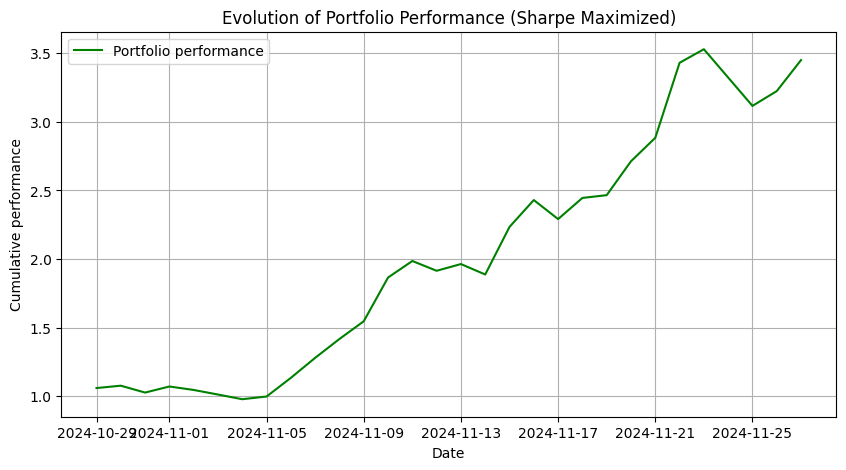

In [20]:
portfolio_returns = np.dot(last_30_returns, optimal_weights)
cumulative_returns = (1 + portfolio_returns).cumprod()

plt.figure(figsize=(10, 5))
plt.plot(last_30_returns.index, cumulative_returns, label="Portfolio performance", color='green')
plt.xlabel("Date")
plt.ylabel("Cumulative performance")
plt.title("Evolution of Portfolio Performance (Sharpe Maximized)")
plt.legend()
plt.grid(True)
plt.show()


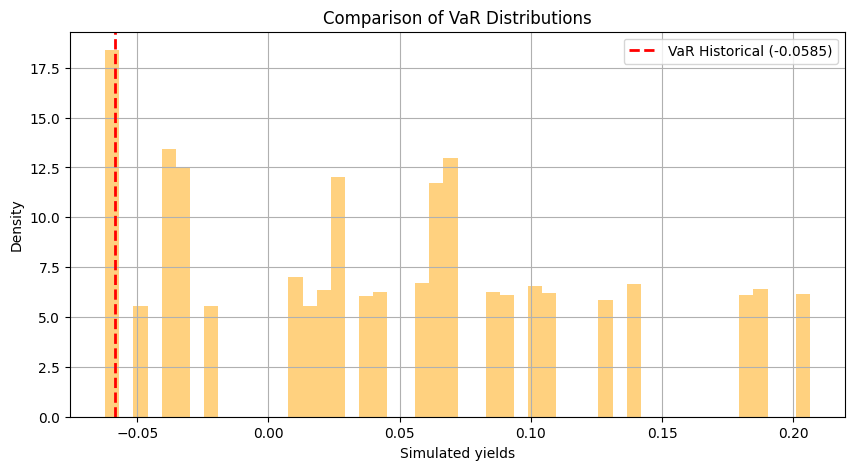

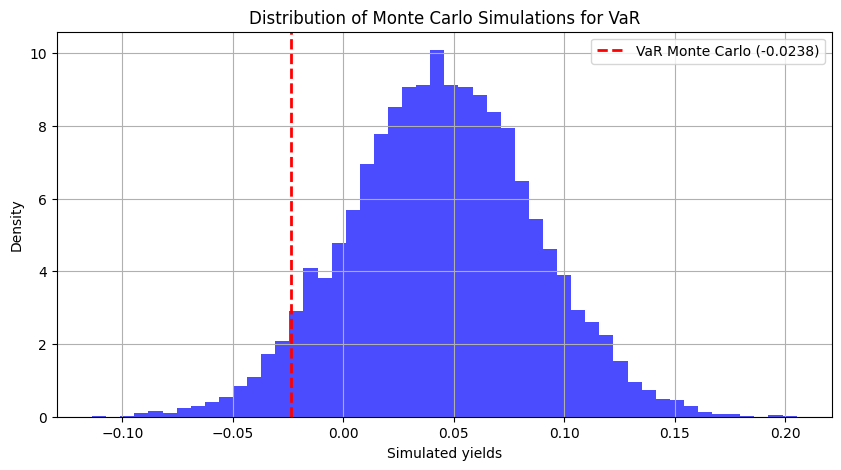

In [21]:
import scipy.stats as stats

confidence_level = 0.95  

portfolio_returns = np.dot(last_30_returns, optimal_weights)

portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
n_simulations = 10000
var_historique = np.percentile(portfolio_returns, (1 - confidence_level) * 100)
# 2️⃣ Simulation pour la VaR Historique (Utilisation des rendements passés)
simulated_returns_historique = np.random.choice(portfolio_returns, size=n_simulations, replace=True)
var_historique_simulated = np.percentile(simulated_returns_historique, (1 - confidence_level) * 100)

simulated_returns = np.random.normal(portfolio_returns.mean(), portfolio_volatility, size=n_simulations)
var_monte_carlo = np.percentile(simulated_returns, (1 - confidence_level) * 100)


# 🔹 Affichage des trois distributions de VaR sur un même graphique

plt.figure(figsize=(10, 5))

# 🔹 2️⃣ VaR Historique
plt.hist(simulated_returns_historique, bins=50, color='orange', alpha=0.5, density=True)
plt.axvline(var_historique_simulated, color='red', linestyle='dashed', linewidth=2, label=f'VaR Historical ({var_historique_simulated:.4f})')


# 🔹 Mise en forme du graphique
plt.title("Comparison of VaR Distributions")
plt.xlabel("Simulated yields")
plt.ylabel("Density")
plt.legend()
plt.grid()

# 🔹 Affichage
plt.show()


plt.figure(figsize=(10, 5))
plt.hist(simulated_returns, bins=50, color='blue', alpha=0.7, density=True)
plt.axvline(var_monte_carlo, color='red', linestyle='dashed', linewidth=2, label=f'VaR Monte Carlo ({var_monte_carlo:.4f})')
plt.xlabel("Simulated yields")
plt.ylabel("Density")
plt.title("Distribution of Monte Carlo Simulations for VaR")
plt.legend()
plt.grid()
plt.show()

📌 VaR Historical   : -0.0579
📌 VaR Monte Carlo  : -0.0238

 Conditional Value at Risk (CVaR) 🔹
📌 CVaR Historical  : -0.0604
📌 CVaR Monte Carlo  : -0.0415


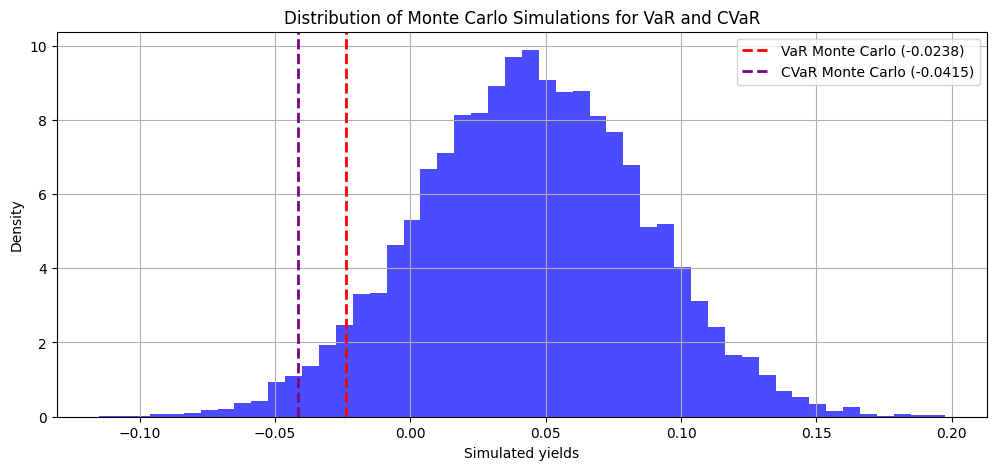

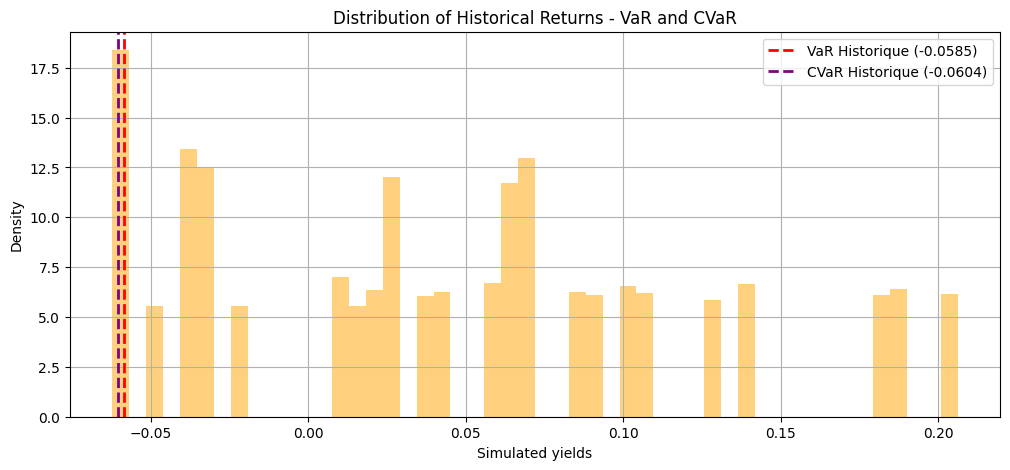

In [22]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

confidence_level = 0.95  
var_alpha = (1 - confidence_level) * 100 



n_simulations = 10000
simulated_returns = np.random.normal(portfolio_returns.mean(), portfolio_volatility, size=n_simulations)

cvar_historique = np.mean(simulated_returns_historique[simulated_returns_historique <= var_historique])  
cvar_monte_carlo = np.mean(simulated_returns[simulated_returns <= var_monte_carlo])  

print(f"📌 VaR Historical   : {var_historique:.4f}")
print(f"📌 VaR Monte Carlo  : {var_monte_carlo:.4f}")
print("\n Conditional Value at Risk (CVaR) 🔹")
print(f"📌 CVaR Historical  : {cvar_historique:.4f}")
print(f"📌 CVaR Monte Carlo  : {cvar_monte_carlo:.4f}")



plt.figure(figsize=(12, 5))


plt.hist(simulated_returns, bins=50, color='blue', alpha=0.7, density=True)
plt.axvline(var_monte_carlo, color='red', linestyle='dashed', linewidth=2, label=f'VaR Monte Carlo ({var_monte_carlo:.4f})')
plt.axvline(cvar_monte_carlo, color='purple', linestyle='dashed', linewidth=2, label=f'CVaR Monte Carlo ({cvar_monte_carlo:.4f})')

plt.title("Distribution of Monte Carlo Simulations for VaR and CVaR")
plt.xlabel("Simulated yields")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(12, 5))
plt.hist(simulated_returns_historique, bins=50, color='orange', alpha=0.5, density=True)
plt.axvline(var_historique_simulated, color='red', linestyle='dashed', linewidth=2, label=f'VaR Historique ({var_historique_simulated:.4f})')
plt.axvline(cvar_historique, color='purple', linestyle='dashed', linewidth=2, label=f'CVaR Historique ({cvar_historique:.4f})')

plt.title("Distribution of Historical Returns - VaR and CVaR")
plt.xlabel("Simulated yields")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()


Optimum weights (CVaR) : [ 0.74325829 -0.93880041  0.61392106  0.58162106]
Sharpe ratio based on optimized CVaR : 0.7957886189415735


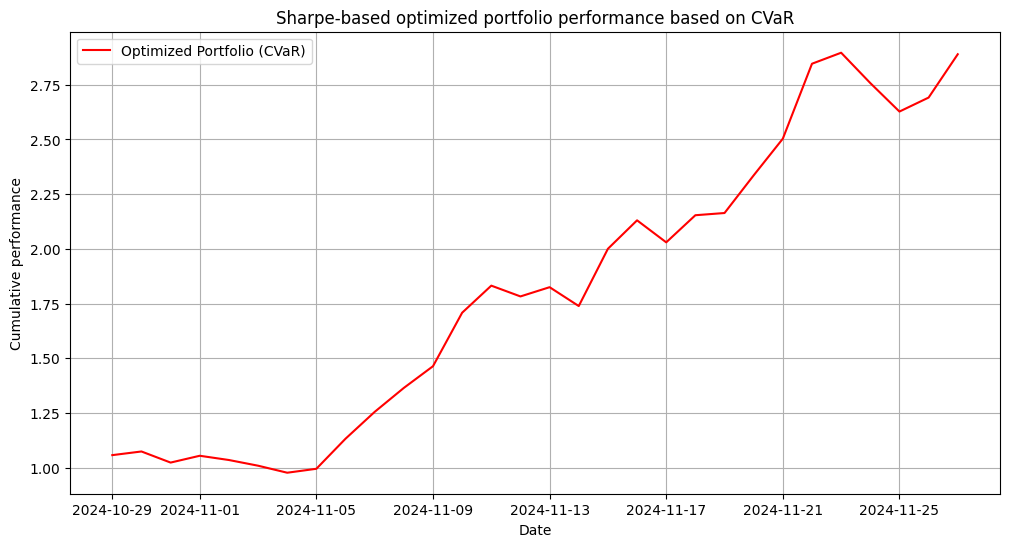

In [72]:
risk_free_rate = 0.03/365 
var_alpha = 0.05  


mu_cvar = last_30_returns.mean().values


volatilities_cvar = np.array(list(vol_dict.values()))
corr_matrix_cvar = last_30_returns.corr().values
cov_matrix_cvar = np.outer(volatilities_cvar, volatilities_cvar) * corr_matrix_cvar  

def portfolio_cvar(weights_cvar, portfolio_returns_cvar, alpha=var_alpha):
    portf_returns_cvar = np.dot(portfolio_returns_cvar, weights_cvar)
    var = np.percentile(portf_returns_cvar, alpha * 100)
    cvar = np.mean(portf_returns_cvar[portf_returns_cvar <= var])  
    return abs(cvar)  

def sharpe_ratio_cvar(weights_cvar, mu, portfolio_returns_cvar, risk_free_rate):
    portf_return_cvar = np.dot(weights_cvar, mu) 
    portf_cvar = portfolio_cvar(weights_cvar, portfolio_returns_cvar) 
    return -(portf_return_cvar - risk_free_rate) / portf_cvar  

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = [(-1,1) for _ in range(len(mu))] 

initial_weights = np.random.uniform(-1, 1, size=len(mu))
initial_weights /= np.sum(np.abs(initial_weights))  

opt_result_cvar = minimize(
    sharpe_ratio_cvar,
    initial_weights,
    args=(mu_cvar, last_30_returns, risk_free_rate),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

optimal_weights_cvar = opt_result_cvar.x
max_sharpe_ratio_cvar = -opt_result_cvar.fun

print("Optimum weights (CVaR) :", optimal_weights_cvar)
print("Sharpe ratio based on optimized CVaR :", max_sharpe_ratio_cvar)


portfolio_cumulative_returns_cvar = (1 + np.dot(last_30_returns, optimal_weights_cvar)).cumprod() 

plt.figure(figsize=(12, 6))
plt.plot(last_30_returns.index, portfolio_cumulative_returns_cvar, label="Optimized Portfolio (CVaR)", color='red')
plt.xlabel("Date")
plt.ylabel("Cumulative performance")
plt.title("Sharpe-based optimized portfolio performance based on CVaR")
plt.legend()
plt.grid()
plt.show()


In [58]:
print("Last 30 days returns:\n", last_30_returns.index())
print("Portfolio returns using optimal weights:\n", np.dot(last_30_returns, optimal_weights_cvar))


TypeError: 'DatetimeIndex' object is not callable

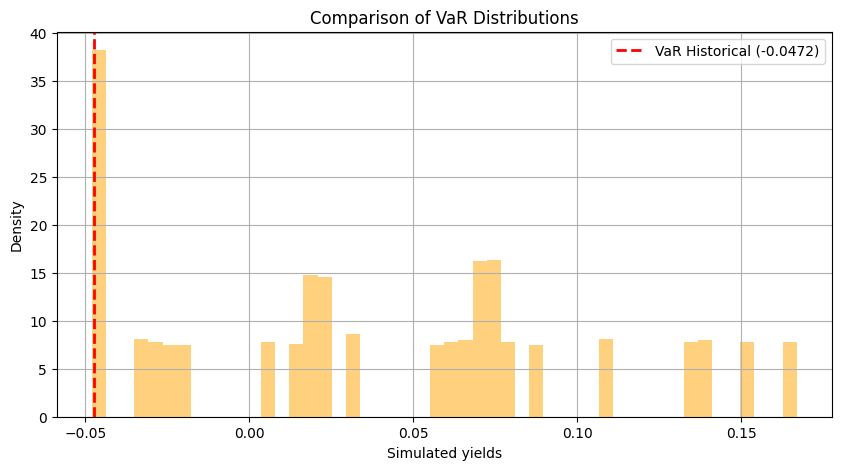

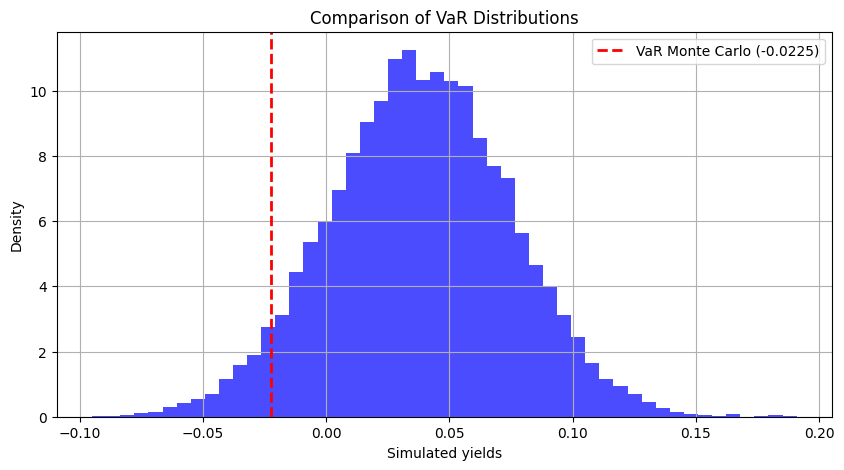

In [24]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

confidence_level = 0.95

portfolio_returns_cvar = np.dot(last_30_returns, optimal_weights_cvar)

portfolio_volatility_cvar = np.sqrt(np.dot(optimal_weights_cvar.T, np.dot(cov_matrix, optimal_weights_cvar)))


var_historique_cvar = np.percentile(portfolio_returns_cvar, (1 - confidence_level) * 100)
simulated_returns_historique_cvar = np.random.choice(portfolio_returns_cvar, size=n_simulations, replace=True)


n_simulations = 10000
simulated_returns_cvar = np.random.normal(portfolio_returns_cvar.mean(), portfolio_volatility_cvar, size=n_simulations)
var_monte_carlo_cvar = np.percentile(simulated_returns_cvar, (1 - confidence_level) * 100)
plt.figure(figsize=(10, 5))
plt.hist(simulated_returns_historique_cvar, bins=50, color='orange', alpha=0.5, density=True)
plt.axvline(var_historique_cvar, color='red', linestyle='dashed', linewidth=2, label=f'VaR Historical ({var_historique_cvar:.4f})')
plt.title("Comparison of VaR Distributions")
plt.xlabel("Simulated yields")
plt.ylabel("Density")
plt.legend()
plt.grid()

# 🔹 Affichage
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(simulated_returns_cvar, bins=50, color='blue', alpha=0.7, density=True)
ax.axvline(var_monte_carlo_cvar, color='red', linestyle='dashed', linewidth=2, label=f'VaR Monte Carlo ({var_monte_carlo_cvar:.4f})')
ax.set_xlabel("Simulated yields")
ax.set_ylabel("Density")
ax.set_title("Comparison of VaR Distributions")
ax.legend()
ax.grid()
plt.show()


📌 VaR Historical     : -0.0472
📌 CVaR Historical      : -0.0475
📌 VaR Monte Carlo      : -0.0202
📌 CVaR Monte Carlo     : -0.0357


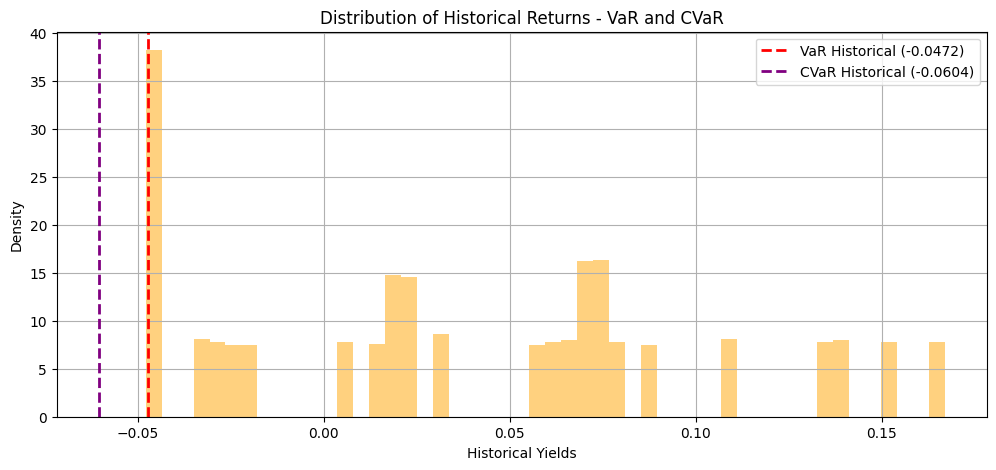

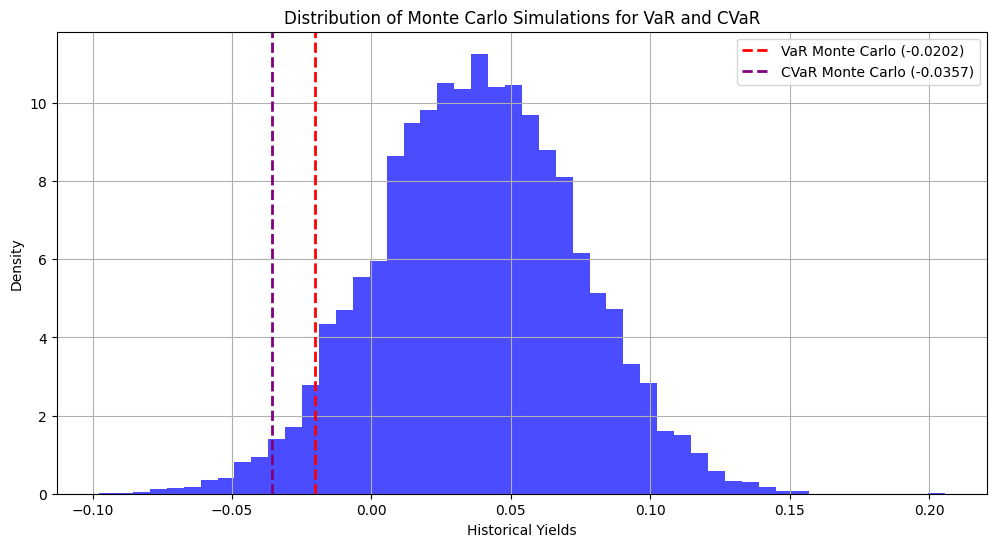

In [25]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

confidence_level = 0.95

n_simulations = 10000
simulated_returns_cvar = np.random.normal(portfolio_returns_cvar.mean(), portfolio_volatility_cvar, size=n_simulations)
var_monte_carlo_cvar = np.percentile(simulated_returns_cvar, (1 - confidence_level) * 100)

# 🔹 5️⃣ Calcul de la CVaR Historique (moyenne des pertes au-delà de la VaR)
cvar_historique_cvar = portfolio_returns_cvar[portfolio_returns_cvar <= var_historique_cvar].mean()

cvar_monte_carlo_cvar = simulated_returns_cvar[simulated_returns_cvar <= var_monte_carlo_cvar].mean()

print(f"📌 VaR Historical     : {var_historique_cvar:.4f}")
print(f"📌 CVaR Historical      : {cvar_historique_cvar:.4f}")
print(f"📌 VaR Monte Carlo      : {var_monte_carlo_cvar:.4f}")
print(f"📌 CVaR Monte Carlo     : {cvar_monte_carlo_cvar:.4f}")


plt.figure(figsize=(12, 5))
plt.hist(simulated_returns_historique_cvar, bins=50, color='orange', alpha=0.5, density=True)
plt.axvline(var_historique_cvar, color='red', linestyle='dashed', linewidth=2, label=f'VaR Historical ({var_historique_cvar:.4f})')
plt.axvline(cvar_historique, color='purple', linestyle='dashed', linewidth=2, label=f'CVaR Historical ({cvar_historique:.4f})')

plt.title("Distribution of Historical Returns - VaR and CVaR")
plt.xlabel("Historical Yields")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()
# 🔹 Visualisation des distributions avec VaR et CVaR
plt.figure(figsize=(12, 6))
plt.hist(simulated_returns_cvar, bins=50, color='blue', alpha=0.7, density=True)
plt.axvline(var_monte_carlo_cvar, color='red', linestyle='dashed', linewidth=2, label=f'VaR Monte Carlo ({var_monte_carlo_cvar:.4f})')
plt.axvline(cvar_monte_carlo_cvar, color='purple', linestyle='dashed', linewidth=2, label=f'CVaR Monte Carlo ({cvar_monte_carlo_cvar:.4f})')
plt.xlabel("Historical Yields")
plt.ylabel("Density")
plt.title("Distribution of Monte Carlo Simulations for VaR and CVaR")
plt.legend()
plt.grid()
plt.show()

